# JAX as an accelerated numpy

In [2]:
import jax
import numpy as np
import jax.numpy as jnp

# Classic numpy implementation
def selu_np(x, alpha=1.67, lmbda=1.05):
  return lmbda * np.where(x > 0, x, alpha * np.exp(x) - alpha)

# JAX implementation with jnp as a dropoff instead of np
# Works on accelerators
def selu_jax(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

# Compiled version of the JAX implementation
# Works on accelerators
jitted_selu_jax = jax.jit(selu_jax)
jitted_selu_numpy = jax.jit(selu_np)

In [7]:
jitted_selu_numpy(x)

TracerArrayConversionError: ignored

TracerArrayConversionError: ignored

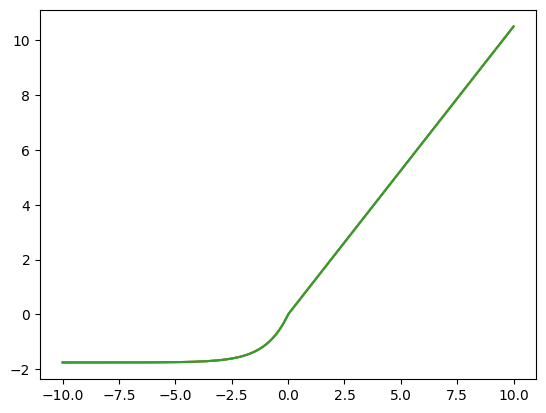

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, int(1e6))

plt.plot(x, selu_np(x))
plt.plot(x, selu_jax(x))
plt.plot(x, jitted_selu_jax(x));
plt.plot(x, jitted_selu_numpy(x));


In [4]:
x = np.linspace(-10, 10, int(1e6))

%timeit selu_np(x)

x = jax.device_put(x) # We force x to live on the GPU so it isn't tranfered

%timeit selu_jax(x).block_until_ready()
%timeit jitted_selu_jax(x).block_until_ready()
%timeit jitted_selu_numpy(x).block_until_ready()

12.1 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
930 µs ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
146 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


TracerArrayConversionError: ignored

# JAX as an autodifferentiable numpy

Most of the functions written in JAX are differentiable, this mean you can easily access the gradient, derivative, jacobian, hessian etc. by simply calling the grad function

```
def f(x):
    ...

grad_f = grad(f)
```

This is usefull in many situations, we illustrate the use of grad here to build a Newton-Raphson solver. We want to find the intersection between two functions $f_1$ and $f_2$, to do so, we solve for $f_1(x) - f_2(x) = g(x) = 0$
This problem can be solved using the Newton-Raphson root-finding algorithm, choosing an initial value $x_0$ and iterating with

$$ x_{n+1} = x_n - \frac{g(x_n)}{g'(x_n)}$$


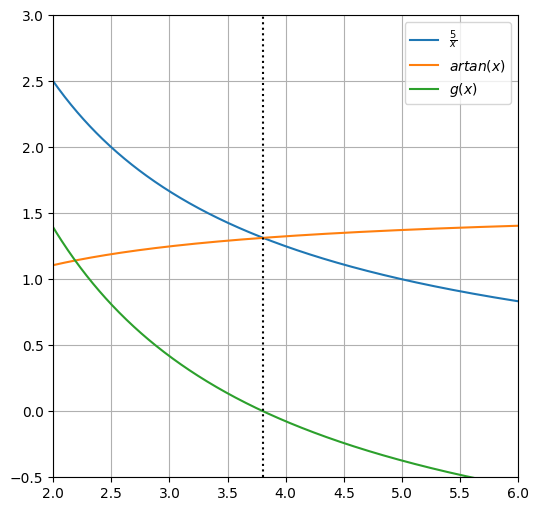

In [ ]:
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)


def f_1(x):

  return 5/x

def f_2(x):

  return jnp.arctan(x)

def g(x):

  return f_1(x) - f_2(x)

x = np.linspace(1, 10, 1000)

# Root by wolfram
true_root = 3.8056450482688104

plt.figure(figsize=(6,6))
plt.plot(x, f_1(x), label=r'$\frac{5}{x}$')
plt.plot(x, f_2(x), label=r'$artan(x)$')
plt.plot(x, g(x), label=r'$g(x)$')
plt.axvline(true_root, color='black', linestyle='dotted')
plt.xlim(2,6)
plt.ylim(-0.5,3)
plt.grid()
plt.legend();

In [ ]:
@jax.jit
def newton_step(x):

  return x - g(x)/jax.grad(g)(x), x

x1 = np.inf #Dummy value
x2 = 5. #Starting point

tol = 1e-12

n_iter = 0

while jnp.abs(x1 - x2) > tol:

  x2, x1 = newton_step(x2)
  n_iter += 1

print(f'Root is approximately x = {(x1 + x2)/2} +- {tol} after {n_iter} iterations')

Root is approximately x = 3.8056450482688104 +- 1e-12 after 6 iterations


In [ ]:
def newton_step(x):

  return x - g(x)/jax.grad(g)(x), x

x1 = np.inf #Dummy value
x2 = 5. #Starting point

tol = 1e-12

n_iter = 0

while jnp.abs(x1 - x2) > tol:

  x2, x1 = newton_step(x2)
  n_iter += 1

print(f'Root is approximately x = {(x1 + x2)/2} +- {tol} after {n_iter} iterations')

Root is approximately x = 3.8056450482688104 +- 1e-12 after 6 iterations
